
Faryadell Simulation Framework (FSF) - Version 1.0.0
The simulation has kicked off! (2023/04/08, 09:35:02)
-------------------------------------------------------------------------------
  Current step    |  All steps       |  Progress (%)    |  Remained time (m:s) 
-------------------------------------------------------------------------------
  594             |  60000           |  1               |  3:20                
  990             |  60000           |  2               |  4:58                
  1630            |  60000           |  3               |  3:2                 
  2223            |  60000           |  4               |  3:15                
  2860            |  60000           |  5               |  2:59                
  3481            |  60000           |  6               |  3:2                 
  4096            |  60000           |  7               |  3:2                 
  4738            |  60000           |  8               |  2:52                
  5347      

<Figure size 640x480 with 0 Axes>

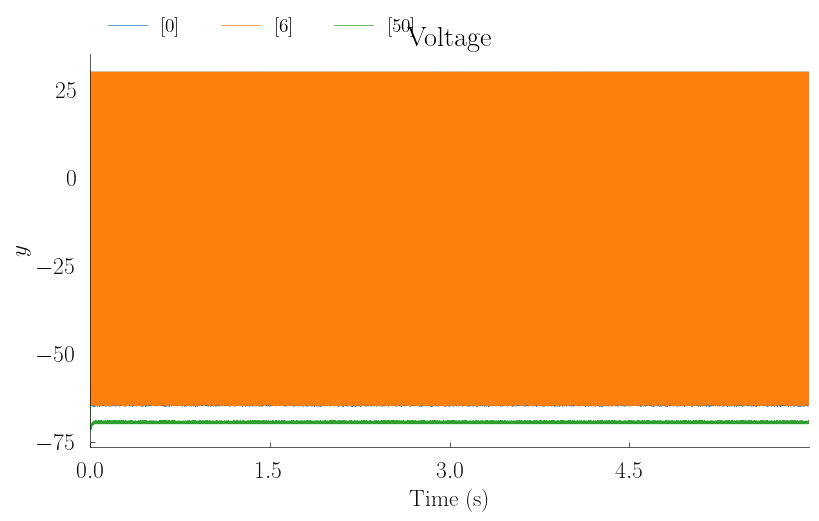

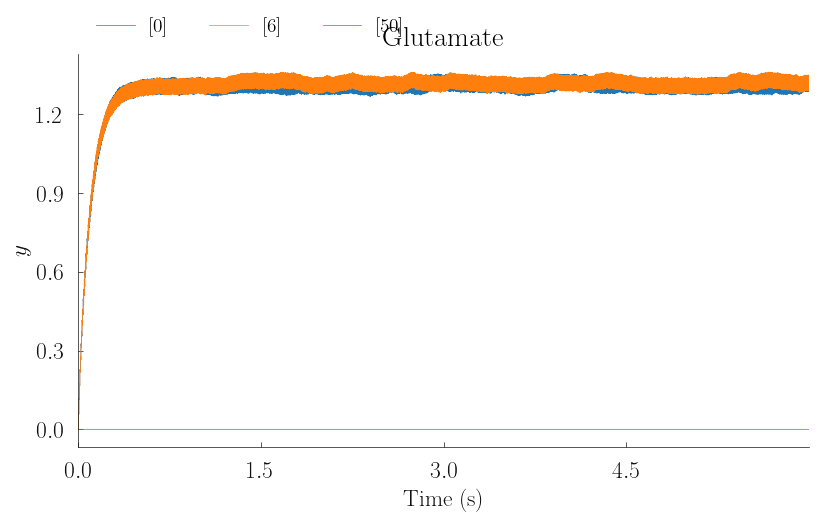

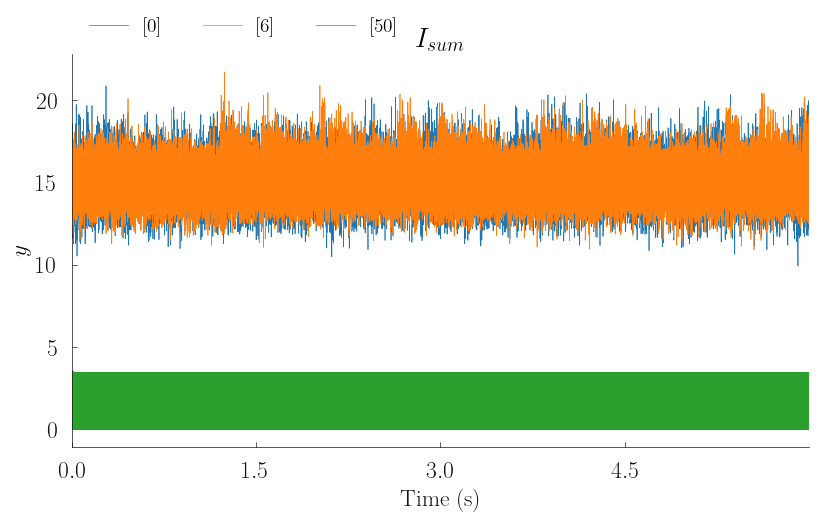

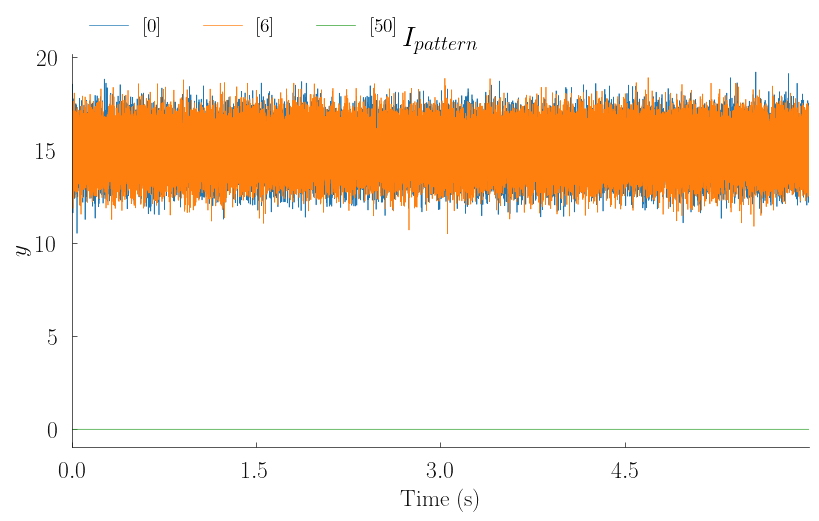

C:\Users\abolf\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


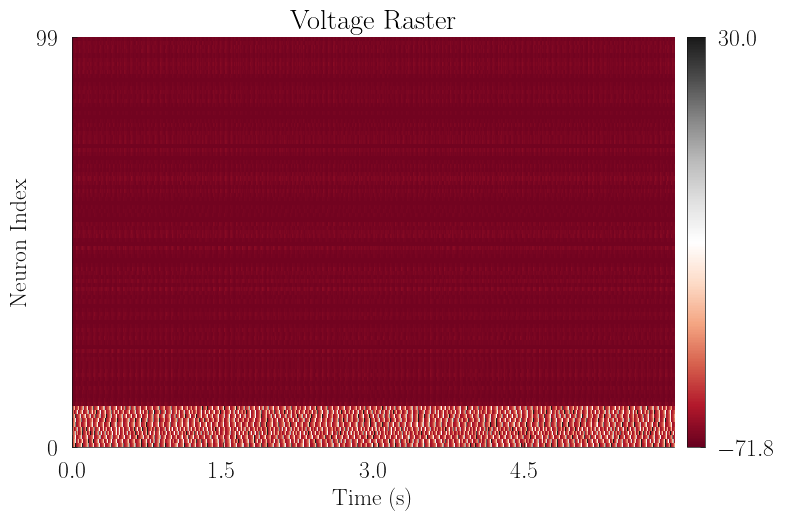

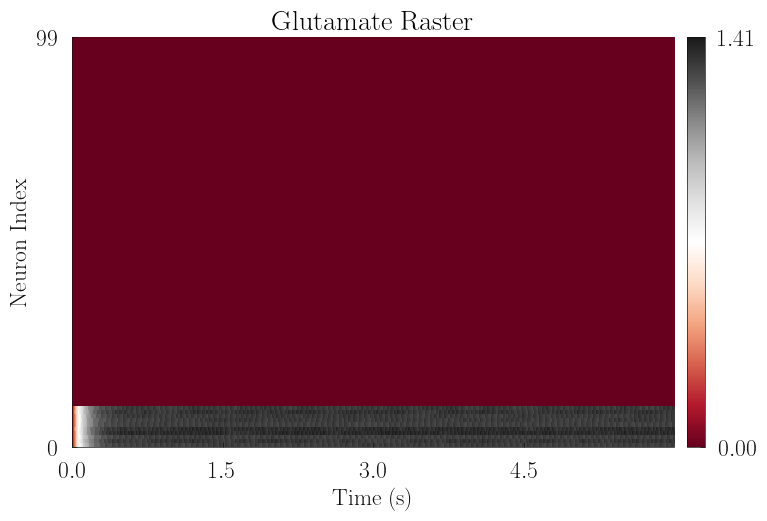

Everything has gone right.

Faryadell Simulation Framework (FSF) - Version 1.0.0
The simulation has kicked off! (2023/04/08, 09:38:56)
-------------------------------------------------------------------------------
  Current step    |  All steps       |  Progress (%)    |  Remained time (m:s) 
-------------------------------------------------------------------------------
  557             |  60000           |  1               |  3:33                
  1117            |  60000           |  2               |  3:30                
  1708            |  60000           |  3               |  3:17                
  2259            |  60000           |  4               |  3:30                
  2832            |  60000           |  5               |  3:20                
  3401            |  60000           |  6               |  3:19                
  3979            |  60000           |  7               |  3:14                
  4568            |  60000           |  8               |  3:8   

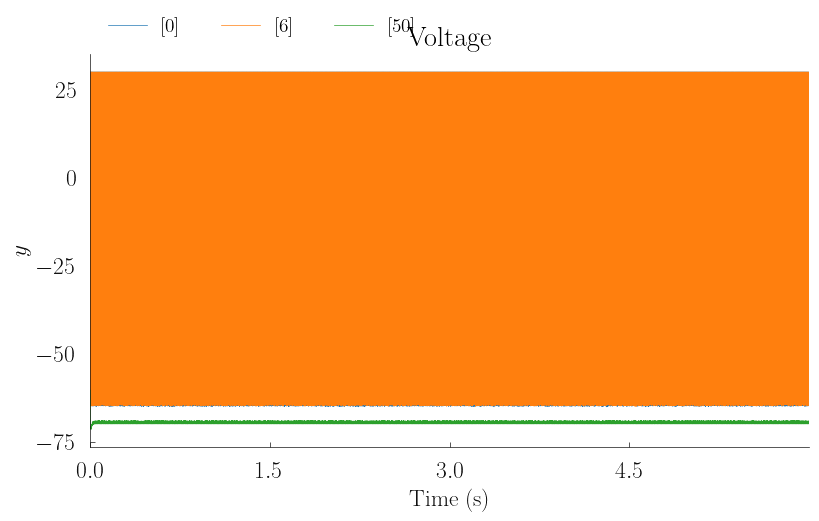

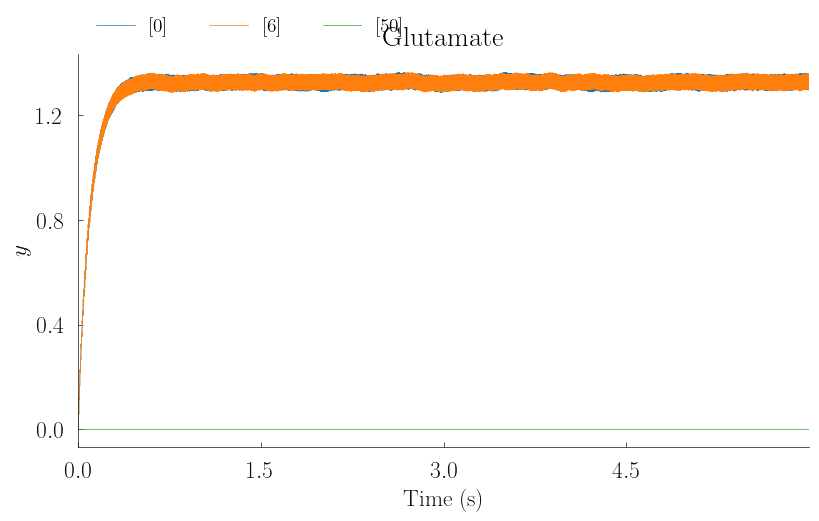

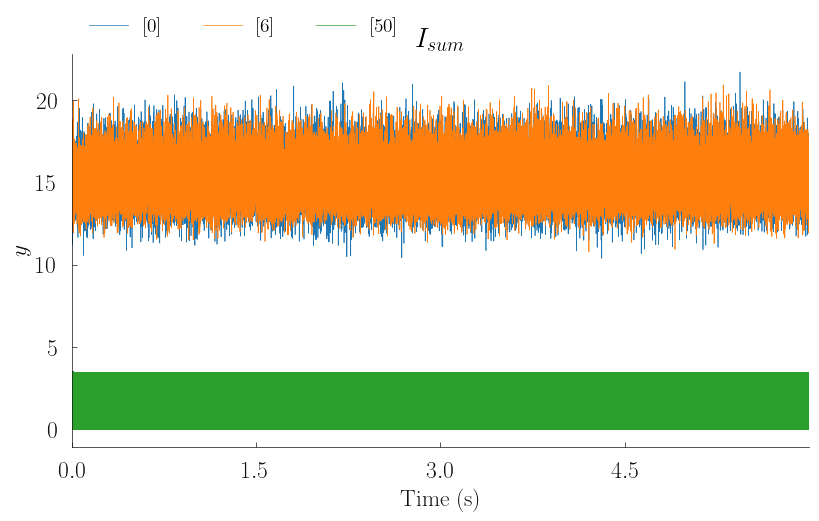

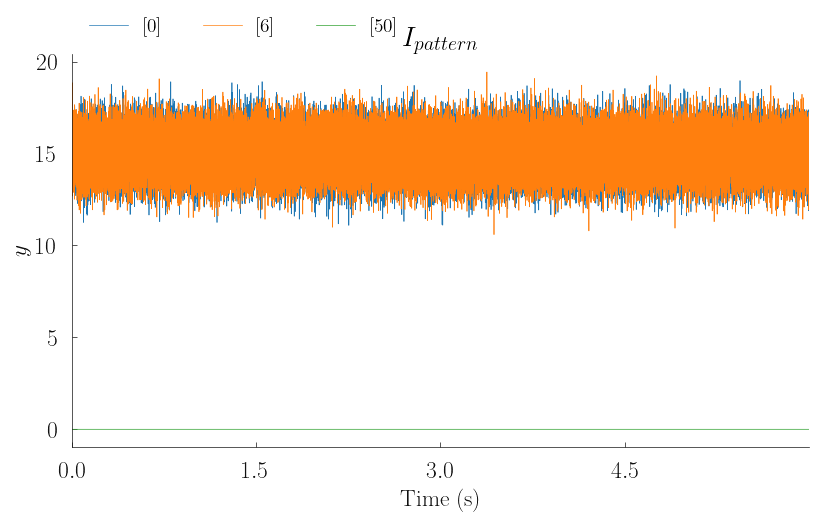

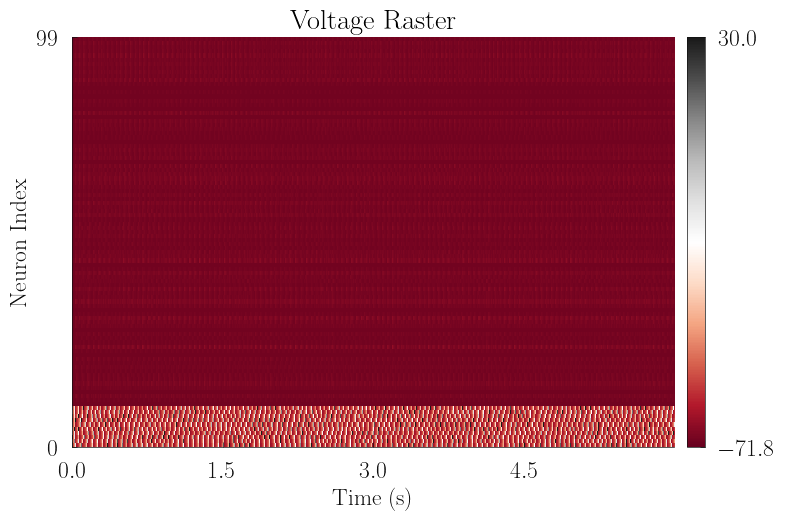

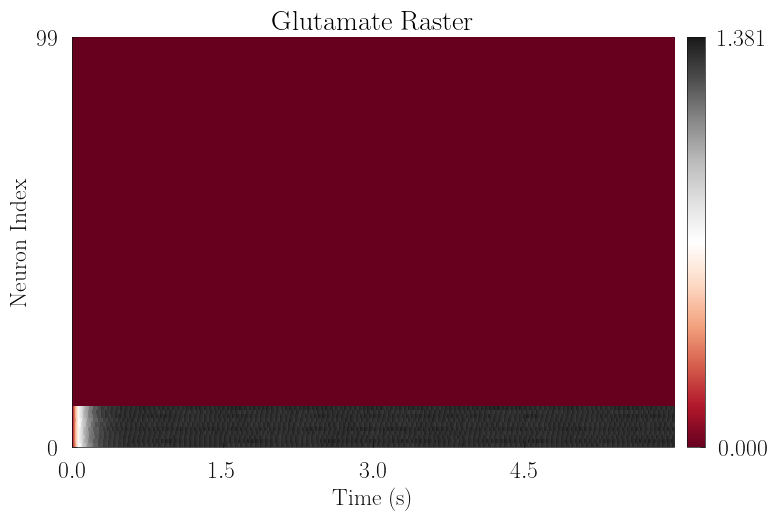

Everything has gone right.


In [1]:
from main import *

params, signals, models = main()
print("Everything has gone right.")

In [19]:
from core.lib.pyRequirment import *

In [65]:
a = np.random.randn(2, 3, 2)*0
a

array([[[-0., -0.],
        [ 0.,  0.],
        [ 0.,  0.]],

       [[-0.,  0.],
        [-0.,  0.],
        [-0.,  0.]]])

In [67]:
b = np.random.randn(2, 3, 4)*0 + 1
b

array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]])

In [68]:
c = np.concatenate((a,b), axis=2)
c

array([[[-0., -0.,  1.,  1.,  1.,  1.],
        [ 0.,  0.,  1.,  1.,  1.,  1.],
        [ 0.,  0.,  1.,  1.,  1.,  1.]],

       [[-0.,  0.,  1.,  1.,  1.,  1.],
        [-0.,  0.,  1.,  1.,  1.,  1.],
        [-0.,  0.,  1.,  1.,  1.,  1.]]])

In [71]:
c[:,:,2]

array([[1., 1., 1.],
       [1., 1., 1.]])